## MS COCO 데이터를 한글캡셔닝으로 학습시킨 모델
### 텐서플로우 케라스 토크나이저를 사용하였으며, 세부내용은 아래와 같습니다.

학습 데이터 수 : 123287장(사진), 616767문장(캡션수)<br>
top_k = 73000 / vocab_size = 73001 / max_length = 52<br>
Batch_size = 64, Buffer_size = 1000, embedding_dim = 256<br>
units = 512 / features_shape = 2048 / attention_features_shape = 64<br>

Epoch 1 Loss 0.910762<br>
Epoch 2 Loss 0.774115<br>
Epoch 3 Loss 0.722089<br>
Epoch 4 Loss 0.679618<br>


In [219]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pandas as pd
from tqdm import tqdm

In [220]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [221]:
cd /content/drive/MyDrive/data/project03

/content/drive/MyDrive/data/project03


In [146]:
# # Download image files / 모델 테스트용 사진으로 사용하기 위해 다운로드 하는 것이므로 반드시 안하셔도 됩니다.
# # 해당 학습모델을 학습시킬때 사용한 데이터 셋이므로 정확도는 높게 나옵니다.
# image_folder = '/val014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('val2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin='http://images.cocodataset.org/zips/val2014.zip',
#                                       extract=True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)

In [222]:
# 코랩에 직접적으로 다운하여 작업시 경로변수 설정
PATH = 'multi/MultiModule-002/'

In [223]:
df = pd.read_csv('multi/멀티모달_데이터정리(완료).csv')
df

,사진경로,사진이름,캡셔닝_데이터(종합),캡셔닝_데이터
0,C:/Workspace/python/빅데이터 지능형서비스 개발 팀프로젝트/Final...,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자들이 있다
1,C:/Workspace/python/빅데이터 지능형서비스 개발 팀프로젝트/Final...,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자들은 서로 쳐다보고있다
2,C:/Workspace/python/빅데이터 지능형서비스 개발 팀프로젝트/Final...,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자는 검정머리이다
3,C:/Workspace/python/빅데이터 지능형서비스 개발 팀프로젝트/Final...,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자는 흰 셔츠를 입고있다다다다다다다
4,C:/Workspace/python/빅데이터 지능형서비스 개발 팀프로젝트/Final...,KETI_SHOT_0000145756_KM_0000000448.jpg,"['남자들이 있다', '남자들은 서로 쳐다보고있다', '남자는 검정머리이다', '남...",남자는 옆을 보고있다
...,...,...,...,...
119840,C:/Workspace/python/빅데이터 지능형서비스 개발 팀프로젝트/Final...,KETI_SHOT_0000148199_KM_0000004318.jpg,"['여자가 앞쪽을 보고 있다', '여자는 입을 다물고 있다', '여자는 외투를 입었...",여자가 앞쪽을 보고 있다
119841,C:/Workspace/python/빅데이터 지능형서비스 개발 팀프로젝트/Final...,KETI_SHOT_0000148199_KM_0000004318.jpg,"['여자가 앞쪽을 보고 있다', '여자는 입을 다물고 있다', '여자는 외투를 입었...",여자는 입을 다물고 있다
119842,C:/Workspace/python/빅데이터 지능형서비스 개발 팀프로젝트/Final...,KETI_SHOT_0000148199_KM_0000004318.jpg,"['여자가 앞쪽을 보고 있다', '여자는 입을 다물고 있다', '여자는 외투를 입었...",여자는 외투를 입었다다다다다다다다
119843,C:/Workspace/python/빅데이터 지능형서비스 개발 팀프로젝트/Final...,KETI_SHOT_0000148199_KM_0000004318.jpg,"['여자가 앞쪽을 보고 있다', '여자는 입을 다물고 있다', '여자는 외투를 입었...",여자의 외투에는 털이 달려있다


In [224]:
annotations = df[['사진이름', '캡셔닝_데이터']]
annotations.columns = ['file_path', 'caption_ko']
annotations

,file_path,caption_ko
0,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들이 있다
1,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들은 서로 쳐다보고있다
2,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 검정머리이다
3,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 흰 셔츠를 입고있다다다다다다다
4,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 옆을 보고있다
...,...,...
119840,KETI_SHOT_0000148199_KM_0000004318.jpg,여자가 앞쪽을 보고 있다
119841,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 입을 다물고 있다
119842,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 외투를 입었다다다다다다다다
119843,KETI_SHOT_0000148199_KM_0000004318.jpg,여자의 외투에는 털이 달려있다


In [307]:
annotations = annotations.drop(annotations[annotations['file_path'] == 'KETI_SHOT_0000123063_KM_0000000620.jpg'].index)
annotations.reset_index(drop=True, inplace=True)
annotations


,file_path,caption_ko
0,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들이 있다
1,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들은 서로 쳐다보고있다
2,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 검정머리이다
3,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 흰 셔츠를 입고있다
4,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 옆을 보고있다
...,...,...
119820,KETI_SHOT_0000148199_KM_0000004318.jpg,여자가 앞쪽을 보고 있다
119821,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 입을 다물고 있다
119822,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 외투를 입었다
119823,KETI_SHOT_0000148199_KM_0000004318.jpg,여자의 외투에는 털이 달려있다


In [291]:
annotations = annotations.drop(annotations[annotations['file_path'] == 'KETI_SHOT_0000123064_KM_0000000685.jpg'].index)
annotations.reset_index(drop=True, inplace=True)
annotations


,file_path,caption_ko
0,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들이 있다
1,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들은 서로 쳐다보고있다
2,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 검정머리이다
3,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 흰 셔츠를 입고있다
4,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 옆을 보고있다
...,...,...
119825,KETI_SHOT_0000148199_KM_0000004318.jpg,여자가 앞쪽을 보고 있다
119826,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 입을 다물고 있다
119827,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 외투를 입었다
119828,KETI_SHOT_0000148199_KM_0000004318.jpg,여자의 외투에는 털이 달려있다


In [277]:
annotations = annotations.drop(annotations[annotations['file_path'] == 'KETI_SHOT_0000123065_KM_0000000762.jpg'].index)
annotations.reset_index(drop=True, inplace=True)
annotations

,file_path,caption_ko
0,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들이 있다
1,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들은 서로 쳐다보고있다
2,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 검정머리이다
3,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 흰 셔츠를 입고있다
4,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 옆을 보고있다
...,...,...
119830,KETI_SHOT_0000148199_KM_0000004318.jpg,여자가 앞쪽을 보고 있다
119831,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 입을 다물고 있다
119832,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 외투를 입었다
119833,KETI_SHOT_0000148199_KM_0000004318.jpg,여자의 외투에는 털이 달려있다


In [253]:
annotations = annotations.drop(annotations[annotations['file_path'] == 'KETI_SHOT_0000123066_KM_0000000800.jpg'].index)
annotations.reset_index(drop=True, inplace=True)
annotations

,file_path,caption_ko
0,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들이 있다
1,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들은 서로 쳐다보고있다
2,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 검정머리이다
3,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 흰 셔츠를 입고있다
4,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 옆을 보고있다
...,...,...
119835,KETI_SHOT_0000148199_KM_0000004318.jpg,여자가 앞쪽을 보고 있다
119836,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 입을 다물고 있다
119837,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 외투를 입었다다
119838,KETI_SHOT_0000148199_KM_0000004318.jpg,여자의 외투에는 털이 달려있다


In [254]:
import re
for i in range(len(annotations['caption_ko'])):
  if '다다다다다다다' in annotations['caption_ko'][i]:
    annotations['caption_ko'][i] = re.sub('다다다다다다다', '다' ,annotations['caption_ko'][i])
annotations

,file_path,caption_ko
0,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들이 있다
1,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들은 서로 쳐다보고있다
2,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 검정머리이다
3,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 흰 셔츠를 입고있다
4,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 옆을 보고있다
...,...,...
119835,KETI_SHOT_0000148199_KM_0000004318.jpg,여자가 앞쪽을 보고 있다
119836,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 입을 다물고 있다
119837,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 외투를 입었다다
119838,KETI_SHOT_0000148199_KM_0000004318.jpg,여자의 외투에는 털이 달려있다


In [256]:
import re
for i in range(len(annotations['caption_ko'])):
  if '다다' in annotations['caption_ko'][i]:
    annotations['caption_ko'][i] = re.sub('다다', '다' ,annotations['caption_ko'][i])
annotations

,file_path,caption_ko
0,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들이 있다
1,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들은 서로 쳐다보고있다
2,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 검정머리이다
3,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 흰 셔츠를 입고있다
4,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 옆을 보고있다
...,...,...
119835,KETI_SHOT_0000148199_KM_0000004318.jpg,여자가 앞쪽을 보고 있다
119836,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 입을 다물고 있다
119837,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 외투를 입었다
119838,KETI_SHOT_0000148199_KM_0000004318.jpg,여자의 외투에는 털이 달려있다


In [292]:
annotations.reset_index(drop=True, inplace=True)

In [293]:
annotations

,file_path,caption_ko
0,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들이 있다
1,KETI_SHOT_0000145756_KM_0000000448.jpg,남자들은 서로 쳐다보고있다
2,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 검정머리이다
3,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 흰 셔츠를 입고있다
4,KETI_SHOT_0000145756_KM_0000000448.jpg,남자는 옆을 보고있다
...,...,...
119825,KETI_SHOT_0000148199_KM_0000004318.jpg,여자가 앞쪽을 보고 있다
119826,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 입을 다물고 있다
119827,KETI_SHOT_0000148199_KM_0000004318.jpg,여자는 외투를 입었다
119828,KETI_SHOT_0000148199_KM_0000004318.jpg,여자의 외투에는 털이 달려있다


In [230]:
annotations['caption_ko'][0]

'남자들이 있다'

In [231]:
for i in range(0, 10, 5):
  print(i)

0
5


In [278]:
image_path_to_caption = collections.defaultdict(list)
image_path_to_caption

defaultdict(list, {})

In [294]:
image_path_to_caption = collections.defaultdict(list)
for i in tqdm(range(len(annotations))):
  # caption = []
  # for k in range(5):
  caption = f"<start> {annotations['caption_ko'][i]} <end>"
    # caption.append(caption_a)
  image_path = PATH + annotations['file_path'][i]
  image_path_to_caption[image_path].append(caption)

  0%|          | 0/119830 [00:00<?, ?it/s]

In [295]:
image_path_to_caption

defaultdict(list,
            {'multi/MultiModule-002/KETI_SHOT_0000145756_KM_0000000448.jpg': ['<start> 남자들이 있다 <end>',
              '<start> 남자들은 서로 쳐다보고있다 <end>',
              '<start> 남자는 검정머리이다 <end>',
              '<start> 남자는 흰 셔츠를 입고있다 <end>',
              '<start> 남자는 옆을 보고있다 <end>'],
             'multi/MultiModule-002/KETI_SHOT_0000145755_KM_0000000401.jpg': ['<start> 과일이 있다 <end>',
              '<start> 여자 두명이 나란히 앉아있다 <end>',
              '<start> 술마시고있다 <end>',
              '<start> 여자들 맞은편에 사람이 있다 <end>',
              '<start> 모두 앉아있다 <end>'],
             'multi/MultiModule-002/KETI_SHOT_0000145754_KM_0000000367.jpg': ['<start> 남자가 있다 <end>',
              '<start> 남자가 입을 벌리고있다 <end>',
              '<start> 남자는 검정 머리이다 <end>',
              '<start> 남자는 흰 셔츠를 입었다 <end>',
              '<start> 남자 둘이 나란히 앉아있다 <end>'],
             'multi/MultiModule-002/KETI_SHOT_0000145753_KM_0000000328.jpg': ['<start> 맞은편에 사람이 있다 <end>',
              '<start> 여자 두명이 있다 <end>'

In [296]:
# 딕셔너리 형태로 사진이름과 패딩한 캡션 값 저장
print(len(image_path_to_caption))
image_path_to_caption['multi/MultiModule-002/KETI_SHOT_0000144654_KM_0000000207.jpg']
# image_path_to_caption.keys()

23974


['<start> 여자의 머리가 단발이다 <end>',
 '<start> 여자가 어딘가를 바라보고 있다 <end>',
 '<start> 여자가 입을 벌리고 있다 <end>',
 '<start> 여자가 앉아있다 <end>',
 '<start> 여자의 옆에 남자아이가 앉아있다 <end>']

In [297]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths
print(len(train_image_paths), train_image_paths[0], sep = ' ')

23974 multi/MultiModule-002/KETI_SHOT_0000147045_KM_0000004674.jpg


In [298]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [299]:
train_captions[:5]

['<start> 여자는 앞머리가 있다 <end>',
 '<start> 여자는 흰 셔츠를 입었다 <end>',
 '<start> 여자는 검은 조끼를 입었다 <end>',
 '<start> 여자는 소파에 앉아있다 <end>',
 '<start> 여자는 머리를 묶었다 <end>']

In [300]:
len(img_name_vector), img_name_vector[:6] # 한개의 사진에 달려있는 캡션이 5개 -> 5번째 이미지 벡터의 값이 앞의 내용과 달라짐

(119830,
 ['multi/MultiModule-002/KETI_SHOT_0000147045_KM_0000004674.jpg',
  'multi/MultiModule-002/KETI_SHOT_0000147045_KM_0000004674.jpg',
  'multi/MultiModule-002/KETI_SHOT_0000147045_KM_0000004674.jpg',
  'multi/MultiModule-002/KETI_SHOT_0000147045_KM_0000004674.jpg',
  'multi/MultiModule-002/KETI_SHOT_0000147045_KM_0000004674.jpg',
  'multi/MultiModule-002/KETI_SHOT_0000127593_KM_0000002403.jpg'])

In [301]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [302]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [303]:
# Feel free to change these parameters according to your system's configuration
# 해당 모델에 들어가야하는 필수 변수들이며, 학습시킬때의 수치와 일치화 시켜주었습니다.
top_k = 73000 # 토큰화 코드 확인 : 영어 : 42000 / 한국어 : 73000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
max_length = 38
# num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

119835
multi/MultiModule-002/KETI_SHOT_0000128742_KM_0000005632.jpg
<start> 남자는 눈을 뜨 고있다 <end>
<start> 남자는 입을 벌리고 있다 <end>
<start> 남자가 슬픈 표정을 짓고 있다 <end>
<start> 남자는 앞머리를 내리고 있다 <end>
<start> 여자는 갈색 머리를 하고 있다 <end>


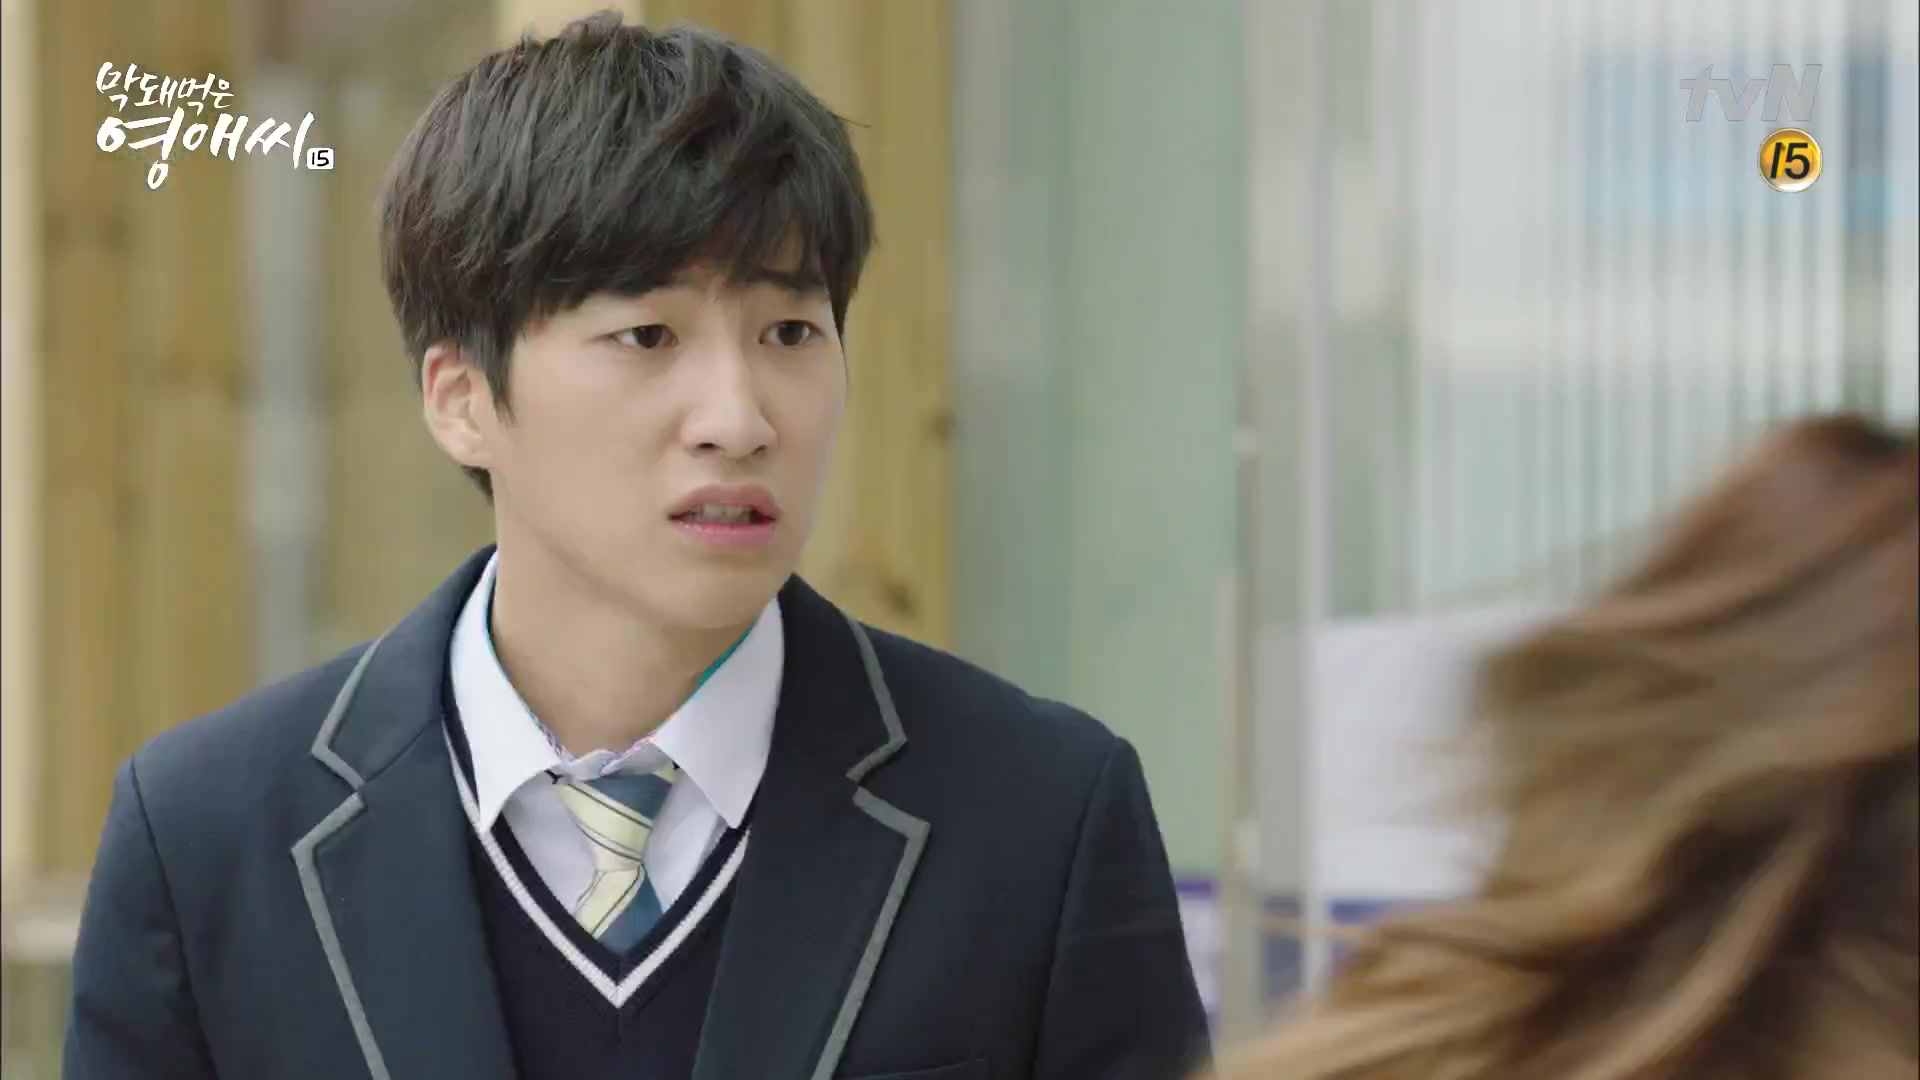

In [289]:
print(len(img_name_vector), img_name_vector[0], sep = '\n')
for i in train_captions[0:img_name_vector.count(train_image_paths[0])]:
  print(i)
Image.open(img_name_vector[0])

In [309]:
from tqdm.notebook import tqdm
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
error = []
try: 
  for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())
except:
  error.append(path)
  print(error)
  pass

  0%|          | 0/23974 [00:00<?, ?it/s]

InvalidArgumentError: ignored

In [310]:
error

[]

In [203]:
encode_train

['multi/MultiModule-002/KETI_SHOT_0000119783_KM_0000000364.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119784_KM_0000000479.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119785_KM_0000000569.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119786_KM_0000000658.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119787_KM_0000000729.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119788_KM_0000000745.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119789_KM_0000000774.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119790_KM_0000001525.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119791_KM_0000001529.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119792_KM_0000001569.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119793_KM_0000001604.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119794_KM_0000001748.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119795_KM_0000001824.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119796_KM_0000001800.jpg',
 'multi/MultiModule-002/KETI_SHOT_0000119797_KM_0000002148.jpg',
 'multi/MultiModule-002/K

In [164]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

In [165]:
import pandas as pd
path = 'Image Captioning(한글모델)/Tensorflow_Keras_T(Check_point)/tokenizer(index_word).csv'
word_index = pd.read_csv(path)
tokenizer.index_word = dict(zip(word_index['key'], word_index['value']))
tokenizer.word_index = dict(zip(word_index['value'], word_index['key']))
tokenizer.index_word[0], tokenizer.word_index['<pad>'] 

('<pad>', 0)

In [166]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [167]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

23969
multi/MultiModule-002/KETI_SHOT_0000140761_KM_0000000385.jpg
['<start> 남자가 화면에 잡히지 않는 누군가를 응시한다 <end>', '<start> 남자가 실내에 있다 <end>', '<start> 남자가 검정색 옷을 입었다다 <end>', '<start> 남자가 옆모습을 보이고 있다 <end>', '<start> 남자가 있는 실내의 벽에 무늬가 있다 <end>']


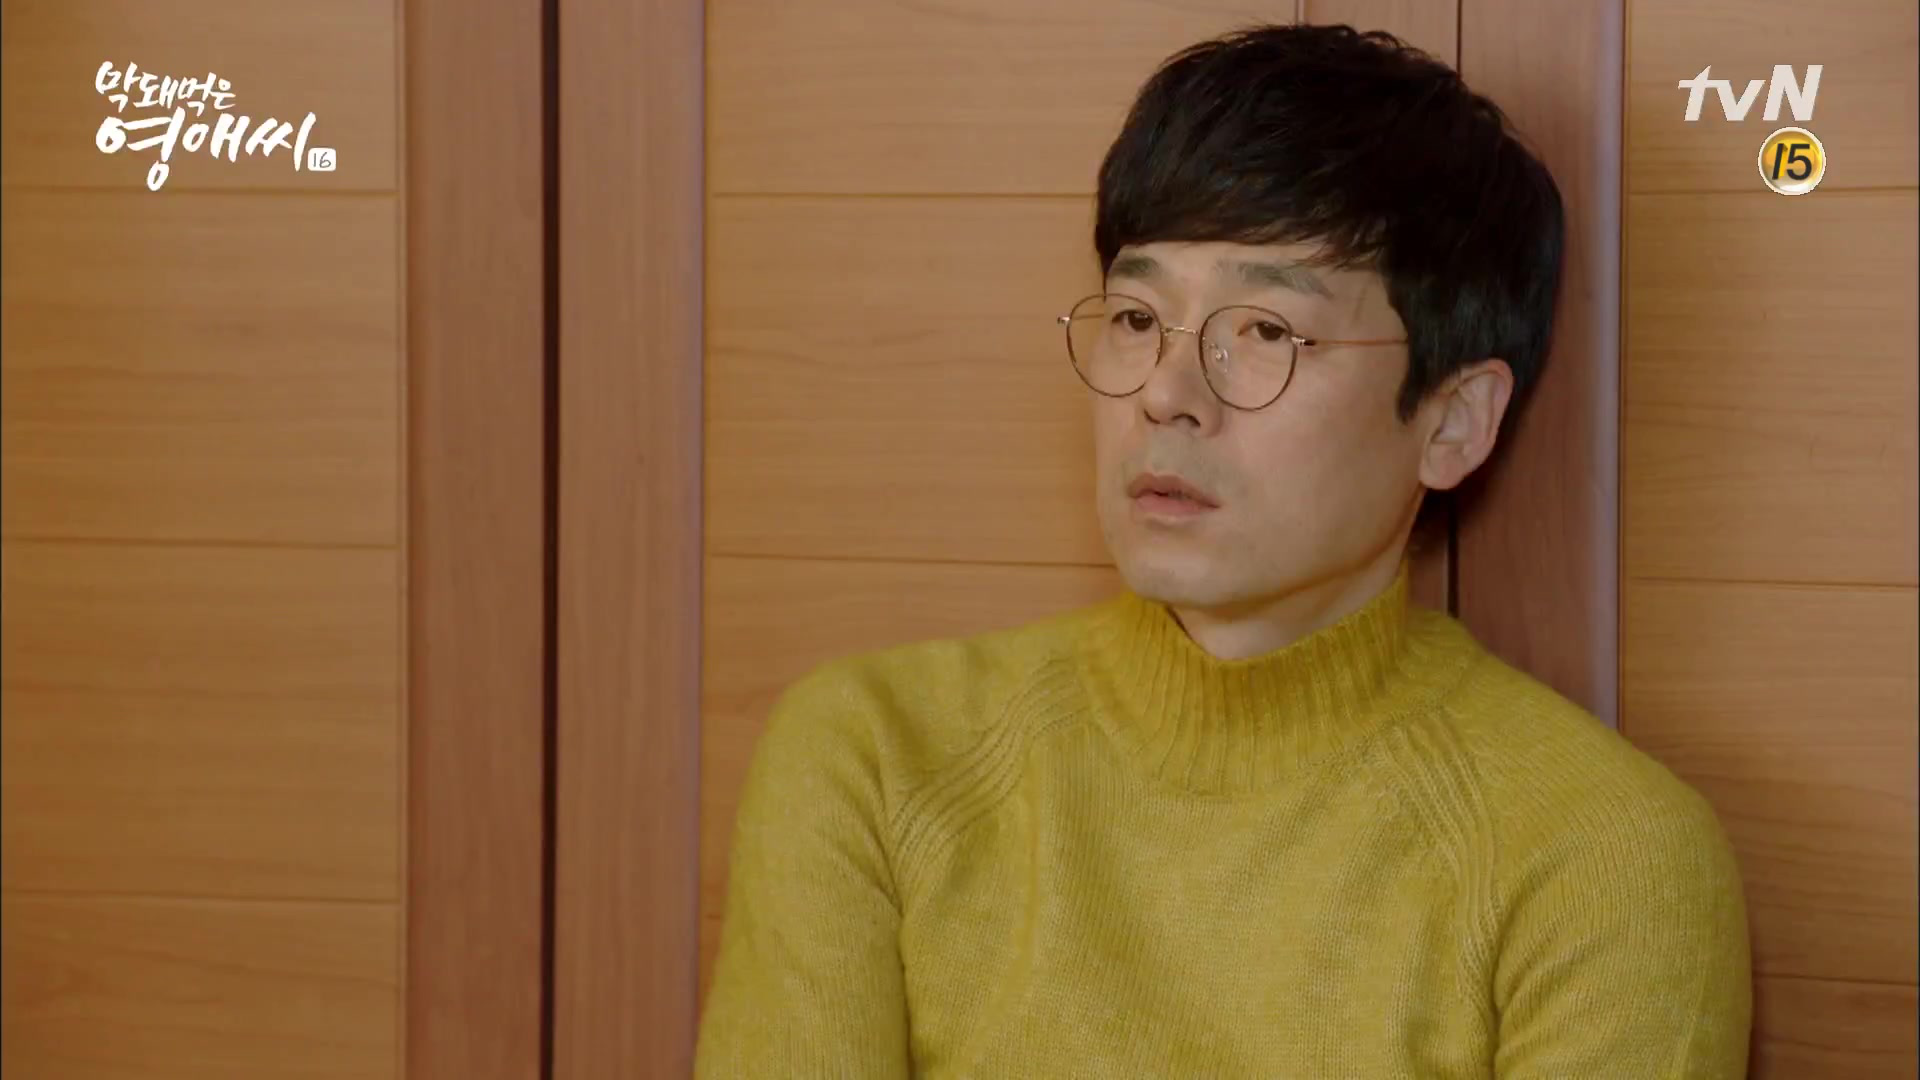

In [168]:
print(len(img_name_vector), img_name_vector[0], sep = '\n')
for i in train_captions[0:img_name_vector.count(train_image_paths[0])]:
  print(i)
Image.open(img_name_vector[0])

## 모델

재미있는 사실: 아래의 디코더는 [Attention을 사용한 신경망 기계 번역](https://www.tensorflow.org/text/tutorials/nmt_with_attention)의 디코더와 동일합니다.

모델 아키텍처는 [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) 논문에서 영감을 얻었습니다.

- 이 예제에서는 InceptionV3의 하위 컨볼루셔널 레이어에서 특성을 추출하여 형상 (8, 8, 2048)의 백터를 제공합니다.
- (64, 2048)의 형상으로 스쿼시합니다.
- 그런 다음, 이 벡터는 CNN Encoder(단일 완전 연결 레이어로 구성)를 통해 전달됩니다.
- RNN(여기서는 GRU)이 다음 단어를 예측하기 위해 이미지를 살펴봅니다.

In [169]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [170]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [171]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [172]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [173]:
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
checkpoint = 'ckpt-4'
checkpoint_use = '/content/drive/MyDrive/2조 멀티캠퍼스 최종 프로젝트/03. 코드/이미지캡셔닝/Image Captioning(한글모델)/Tensorflow_Keras_T(Check_point)/' + checkpoint
ckpt.restore(checkpoint_use)

# 추가 학습

In [174]:
tokenizer.fit_on_texts(train_captions)

In [175]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [176]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [177]:
train_seqs[0]

[1092, 2, 493, 7453, 11742]

In [178]:
len(tokenizer.index_word)

34874

In [179]:
key_list = []
value_list = []
for k, v in tokenizer.index_word.items():
  key_list.append(k)
  value_list.append(v)

In [180]:
import pandas as pd
word_index = pd.DataFrame(columns = ['key', 'value'])
word_index['key'] = key_list
word_index['value'] = value_list
dict(zip(word_index['key'], word_index['value'])) == tokenizer.index_word

True

In [181]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [182]:
# 토큰나이저 속성결과 값 드라이브에 저장(체크포인트 활용하여 작업시 필요수치들)
word_index.to_csv('multi/checkpoint/tokenizer(index_word).csv', index = False)

In [183]:
cap_vector[0]

array([ 1092,     2,   493,  7453, 11742], dtype=int32)

In [185]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [186]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(19175, 19175, 4794, 4794)

In [187]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [188]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [189]:
len(cap_train), cap_train[0] # img_name_train은 이미지 이름

(19175, array([9910,  227, 2611,  122,  738], dtype=int32))

In [190]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [191]:
checkpoint_path = "multi/checkpoint/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50) # max_to_keep=3 : 최신체크포인트 중 몇개까지 저장할 건지 지정하는 옵션

In [192]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [193]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [194]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [195]:
EPOCHS = 5

for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  0%|          | 0/5 [00:00<?, ?it/s]


UnknownError: ignored

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## 캡션!

- evaluate 함수는 여기에서 teacher forcing을 사용하지 않는다는 점을 제외하고 훈련 루프와 유사합니다. 각 타임스텝에서 decoder로의 입력은 hidden state 및 encoder 출력과 함께 이전 예측값입니다.
- 모델이 end 토큰을 예측할 때 예측을 중지합니다.
- 그리고 타임스텝마다 attention 가중치를 저장합니다.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# import os
# path_dir = '/content/val2014/'
# file_dir = os.listdir(path_dir)
# path_dir + file_dir[0]

In [ ]:
import random 
# i = random.randint(0, len(file_dir))
# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-3:]
# image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = '/content/drive/MyDrive/data/project03/testimg/images.jpg'
# image_path = path_dir + file_dir[i]
print(image_path)

for i in range(5):
  result, attention_plot = evaluate(image_path)
  print(f'예측문장{i+1}:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)